In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.utils import set_random_seed

import matplotlib.pyplot as plt

sys.path.append('..')

import MazeEnv.MultiTargetMazeEnv as mtmz
from MazeEnv.MazeEnv import Rewards
from Utils import make_circular_map, clear_files, get_multi_targets_circle_envs
from Evaluation import EvalAndSaveCallback, MultiTargetEvalAndSaveCallback
import Evaluation

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
RUN_NAME="TargetEpsilon0.5_16m_largerBoundries"
os.makedirs(os.path.join("logs/MultiTargets", RUN_NAME), exist_ok=True)

TOTAL_TIME_STEPS = 16_000_000 #number of training timesteps
BUFFER_SIZE = 1_000_000
TIMEOUT_STEPS = 200 # Timeout Steps of each episode 
LEARNING_RATE = 0.5e-5
REDUCE_LR = True
EXPLORATION_NOISE_STD = 0.05
LEARNING_STARTS=20000

BATCH_SIZE=1024

REWARDS = Rewards(target_arrival=1, collision=-1, timeout=0, idle=-0.2e-3, fall=-1)


# EVAL_EPISODES = 50
EVAL_FREQ = 100_000
VIDEO_FREQ = 25

targets = np.genfromtxt("TestTargets/test_coords.csv", delimiter=',')

maze_env, eval_maze_env = get_multi_targets_circle_envs(radius=4,
                                                        targets = targets,
                                                        timeout_steps=TIMEOUT_STEPS,
                                                        rewards=REWARDS,
                                                        monitor_dir=os.path.join("logs/MultiTargets", RUN_NAME, "results"),
                                                        xy_in_obs=False)
 
# create model:
exploration_noise = NormalActionNoise(mean=np.array([0]*8), sigma=np.array([EXPLORATION_NOISE_STD]*8))

def lr_func(progress):
    if progress < 0.33 and REDUCE_LR:
        return LEARNING_RATE/5
    if progress < 0.66 and REDUCE_LR:
        return LEARNING_RATE/20
    return LEARNING_RATE

set_random_seed(10241, True)

model = DDPG(policy="MlpPolicy",
             env=maze_env,
             buffer_size=BUFFER_SIZE,
             learning_rate=lr_func,
             action_noise=exploration_noise,
             device=device,
             train_freq=(1, "episode"),
             learning_starts=LEARNING_STARTS,
             batch_size=BATCH_SIZE,
             verbose=0,
             tensorboard_log="./logs/MultiTargets/tb")

# create callback for evaluation
callback = MultiTargetEvalAndSaveCallback(log_dir=os.path.join("logs/MultiTargets", RUN_NAME),
                                          eval_env=eval_maze_env,
                                          eval_freq=EVAL_FREQ,
                                          eval_video_freq=VIDEO_FREQ,
                                          verbose=1)

In [9]:
# clear old videos: 
clear_files('logs/MultiTargets/*.gif')
clear_files('logs/MultiTargets/*.avi')

In [10]:
start = time.time()


model.learn(total_timesteps=TOTAL_TIME_STEPS,
            callback=callback,
            tb_log_name=RUN_NAME)
 
print("time", time.time() - start)

50000.00 Steps evaluation, avg reward:-19.99, avg episode length: 1000.00, success rate: 0.00
--Saving new best model--
100000.00 Steps evaluation, avg reward:-19.99, avg episode length: 1000.00, success rate: 0.00


KeyboardInterrupt: 

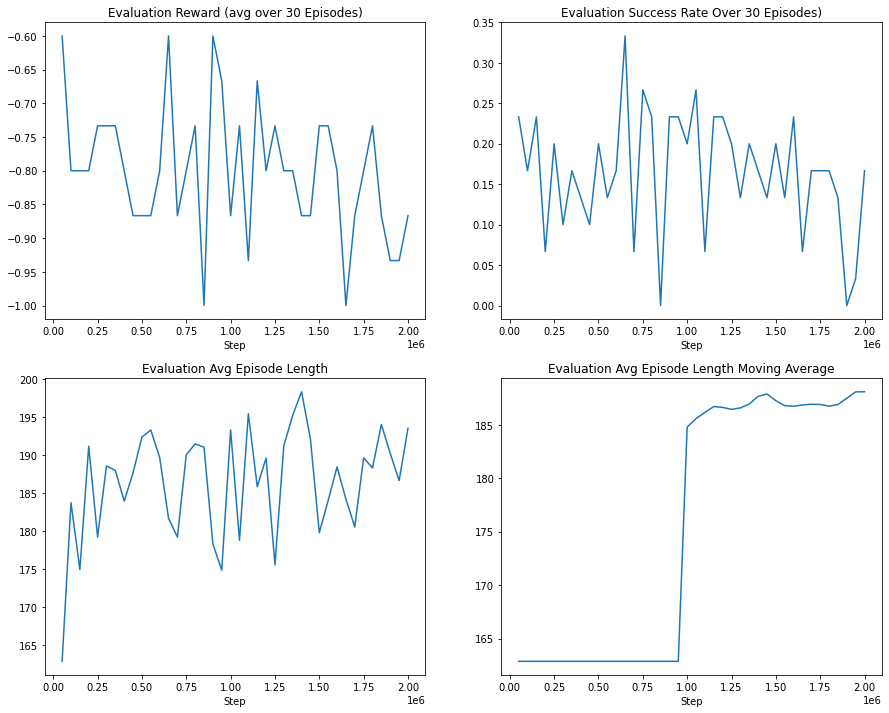

In [34]:
Evaluation.plot_train_eval_results(os.path.join("logs/MultiTargets", RUN_NAME), 50)

In [35]:
from IPython.display import Image
import ipyplot
import glob

# create gifs and plot them:
Evaluation.create_gifs_from_avi(os.path.join("logs/MultiTargets", RUN_NAME))

gifs = glob.glob(os.path.join("logs/MultiTargets", RUN_NAME, "*_steps.gif"))
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
ipyplot.plot_images(gifs, labels, img_width=200)


In [38]:
# # load best model
# best_model = DDPG.load(os.path.join("logs/MultiTargets", RUN_NAME, "best_model"),env=maze_env)

# # evaluate for last final episode (random target)
# episode_reward = Evaluation.record_model(best_model, eval_maze_env, os.path.join("logs/MultiTargets", RUN_NAME, "final", "final"))
# print("Final Evaluation Reward:", episode_reward)

# Evaluation.create_gifs_from_avi(os.path.join("logs/MultiTargets", RUN_NAME, "final"))

# gifs = glob.glob(os.path.join("logs/MultiTargets", RUN_NAME, "final", "final.gif"))
# print(gifs)
# ipyplot.plot_images(gifs, img_width=250)

[ERROR:0] global /tmp/pip-req-build-qm9qliph/opencv/modules/videoio/src/cap.cpp (587) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.2) /tmp/pip-req-build-qm9qliph/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): logs/MultiTargets/repeat5_higherLR_higherNOISE/final/final in function 'icvExtractPattern'




Final Evaluation Reward: -1
[]


IndexError: list index out of range